In [1]:
import numpy as np
import pandas as pd

def f(x1, x2):
    return (1.3356 * (1.5 * (1 - x1)) 
            + np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2))
            + np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))

def GetGrid(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    y = f(x1, x2)
    return x1, x2, y

def create_dataframe(grid):
   x1, x2, y = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': y.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../../results_f/virtual_samples_Matern_0.5.xlsx")

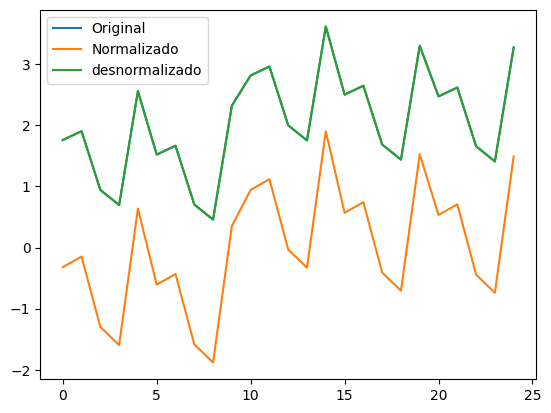

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.lm_model = lm.model.ModelWrapper(self.model)
        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError()
        )

        return(self.lm_model)

2025-07-21 22:36:23.832917: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:36:23.837659: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:36:23.870544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753137383.991449 1750697 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753137384.018446 1750697 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753137384.076497 1750697 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)

    def plot_loss_history(self):
      history = self.results.history
      
      plt.figure(figsize=(8, 5))
      plt.plot(history['loss'], label='Loss de Treinamento')
      plt.plot(history['val_loss'], label='Loss de Validação')
      plt.xlabel('Época')
      plt.ylabel('Loss')
      plt.title('Histórico de Loss')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights("./content/models/initial-weights/initial-.weights.h5")
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
      
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"./content/models/{fileName}.weights.h5"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./content/models/initial-weights/initial-.weights.h5",
                f"./content/models/initial-weights/{fileName}.weights.h5")

  def SaveDataset(self, trainer, fileName):
    path = f"./content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        #trainer.plot_loss_history()
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'./content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando Com amostras virtuais



In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=15)
tester.Loop(sort_by='r2_sup',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36], [48], [60]],
            regularizers=[0.02, 0.2],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.903666,0.658114,0.831870,0.872432,0.051083,0.202958,0.143204,0.038308,0.135343,0.226015,0.868822,0.229574,39.948617,76.913201
model_1_4_8,0.816010,0.584776,0.738436,0.766300,0.097564,0.246495,0.222785,0.070179,0.191753,0.312353,0.749460,0.317272,38.654489,75.619072
model_1_4_7,0.812788,0.582049,0.735357,0.762296,0.099273,0.248114,0.225408,0.071381,0.193536,0.315076,0.745072,0.320038,38.619766,75.584349
model_1_4_6,0.809500,0.579284,0.732213,0.758207,0.101016,0.249755,0.228085,0.072609,0.195338,0.317831,0.740595,0.322836,38.584945,75.549528
model_1_4_5,0.799228,0.570679,0.722372,0.745418,0.106463,0.254864,0.236468,0.076450,0.200910,0.326287,0.726608,0.331426,38.479912,75.444495
model_1_4_4,0.795663,0.567672,0.718999,0.740974,0.108353,0.256649,0.239340,0.077784,0.202810,0.329171,0.721754,0.334355,38.444714,75.409298
model_1_4_3,0.792026,0.564591,0.715568,0.736437,0.110282,0.258478,0.242262,0.079147,0.204734,0.332088,0.716801,0.337318,38.409425,75.374009
model_1_4_2,0.784526,0.558301,0.708463,0.727074,0.114259,0.262212,0.248314,0.081958,0.208666,0.338023,0.706588,0.343346,38.338569,75.303153
model_1_4_1,0.768485,0.544817,0.693192,0.706986,0.122765,0.270216,0.261321,0.087991,0.216856,0.350378,0.684746,0.355896,38.194968,75.159552
model_1_4_0,0.760085,0.537698,0.685457,0.697067,0.127219,0.274443,0.267909,0.090969,0.221020,0.356678,0.673308,0.362295,38.123686,75.088270


DataFrame salvo em ./content/results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.924677,0.669402,0.857648,0.931503,0.039941,0.196257,0.121247,0.036332,0.118937,0.199854,0.897432,0.203001,40.440681,77.405264
model_1_5_8,0.923647,0.669185,0.856490,0.930618,0.040488,0.196386,0.122233,0.036801,0.119785,0.201215,0.896030,0.204384,40.413519,77.378102
model_1_5_7,0.922593,0.668749,0.855262,0.929710,0.041047,0.196645,0.123279,0.037283,0.120645,0.202600,0.894594,0.205791,40.386089,77.350672
model_1_5_6,0.921512,0.668143,0.853979,0.928778,0.041619,0.197005,0.124372,0.037777,0.121516,0.204009,0.893123,0.207221,40.358374,77.322957
model_1_5_5,0.919277,0.666591,0.851288,0.926837,0.042805,0.197926,0.126664,0.038806,0.123293,0.206894,0.890079,0.210152,40.302198,77.266781
model_1_5_4,0.918121,0.665762,0.849888,0.925831,0.043418,0.198418,0.127857,0.039340,0.124217,0.208369,0.888506,0.211651,40.273779,77.238362
model_1_5_3,0.911961,0.663306,0.842240,0.920429,0.046684,0.199876,0.134371,0.042206,0.129063,0.216066,0.880117,0.219468,40.128692,77.093276
model_1_5_2,0.909310,0.661291,0.839041,0.918090,0.048090,0.201072,0.137096,0.043446,0.131116,0.219294,0.876507,0.222748,40.069363,77.033947
model_1_5_1,0.907943,0.660270,0.837391,0.916880,0.048815,0.201678,0.138501,0.044088,0.132158,0.220941,0.874646,0.224421,40.039434,77.004017
model_1_5_0,0.905122,0.659260,0.833596,0.914378,0.050311,0.202278,0.141733,0.045415,0.134271,0.224301,0.870804,0.227834,39.979060,76.943643


DataFrame salvo em ./content/results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.936502,0.675382,0.871100,0.938019,0.033671,0.192707,0.109790,0.035656,0.108730,0.183496,0.913535,0.186386,40.782247,77.746830
model_1_6_8,0.934975,0.674431,0.869212,0.936543,0.034481,0.193272,0.111397,0.036504,0.110078,0.185689,0.911456,0.188614,40.734722,77.699306
model_1_6_7,0.934191,0.673891,0.868234,0.935793,0.034896,0.193592,0.112230,0.036936,0.110772,0.186806,0.910388,0.189748,40.710740,77.675323
model_1_6_6,0.933393,0.673551,0.867331,0.935035,0.035320,0.193794,0.113000,0.037372,0.111481,0.187936,0.909300,0.190896,40.686620,77.651204
model_1_6_5,0.930053,0.671406,0.863280,0.931934,0.037091,0.195068,0.116450,0.039156,0.114437,0.192589,0.904753,0.195622,40.588784,77.553368
model_1_6_4,0.929181,0.670892,0.862262,0.931144,0.037553,0.195373,0.117317,0.039610,0.115189,0.193786,0.903566,0.196837,40.564013,77.528596
model_1_6_3,0.928295,0.670323,0.861207,0.930351,0.038023,0.195710,0.118215,0.040067,0.115945,0.194995,0.902359,0.198066,40.539127,77.503710
model_1_6_1,0.926540,0.670287,0.859641,0.928788,0.038954,0.195732,0.119550,0.040965,0.117411,0.197367,0.899969,0.200475,40.490760,77.455343
model_1_6_0,0.925618,0.669907,0.858688,0.927989,0.039442,0.195957,0.120361,0.041425,0.118170,0.198601,0.898715,0.201728,40.465839,77.430422
model_1_6_2,0.927393,0.669820,0.860175,0.929554,0.038501,0.196009,0.119095,0.040525,0.116705,0.196217,0.901131,0.199307,40.514135,77.478718


DataFrame salvo em ./content/results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  23
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.963156,0.697257,0.909634,0.935862,0.019537,0.179721,0.076969,0.017792,0.079183,0.139775,0.949830,0.141977,41.870871,78.835455
model_1_7_8,0.959799,0.693648,0.903477,0.933163,0.021317,0.181864,0.082213,0.018541,0.084000,0.146005,0.945258,0.148304,41.696469,78.661052
model_1_7_7,0.959098,0.693435,0.902548,0.932535,0.021689,0.181990,0.083004,0.018715,0.084935,0.147273,0.944303,0.149592,41.661872,78.626456
model_1_7_6,0.958735,0.693189,0.902006,0.932203,0.021881,0.182136,0.083465,0.018807,0.085410,0.147924,0.943810,0.150253,41.644235,78.608818
model_1_7_5,0.956391,0.691493,0.898520,0.929948,0.023125,0.183143,0.086434,0.019433,0.088361,0.152068,0.940617,0.154463,41.533706,78.498290
model_1_7_4,0.955970,0.691180,0.897898,0.929524,0.023348,0.183329,0.086964,0.019550,0.088871,0.152800,0.940044,0.155207,41.514497,78.479081
model_1_7_3,0.954652,0.690441,0.896101,0.928166,0.024047,0.183768,0.088495,0.019927,0.090430,0.155070,0.938249,0.157512,41.455517,78.420100
model_1_7_2,0.950699,0.686847,0.890142,0.923832,0.026143,0.185901,0.093571,0.021129,0.094823,0.161688,0.932866,0.164234,41.288349,78.252933
model_1_7_1,0.949601,0.686217,0.888713,0.922567,0.026725,0.186275,0.094788,0.021481,0.095979,0.163478,0.931371,0.166053,41.244301,78.208885
model_1_7_0,0.949034,0.685836,0.887951,0.921904,0.027026,0.186501,0.095437,0.021664,0.096571,0.164395,0.930600,0.166984,41.221938,78.186521


DataFrame salvo em ./content/results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_8,0.969629,0.700980,0.918670,0.974086,0.016105,0.177511,0.069272,0.018845,0.066662,0.126904,0.958644,0.128903,42.257293,79.221877
model_1_8_6,0.967869,0.700756,0.916371,0.972878,0.017038,0.177644,0.071231,0.019723,0.070457,0.130529,0.956248,0.132585,42.144639,79.109223
model_1_8_2,0.965467,0.700270,0.913652,0.971304,0.018312,0.177933,0.073546,0.020868,0.075122,0.135321,0.952977,0.137452,42.000434,78.965018
model_1_8_0,0.964174,0.699730,0.912092,0.970494,0.018997,0.178253,0.074875,0.021458,0.077401,0.137831,0.951216,0.140001,41.926921,78.891504
model_1_8_3,0.965633,0.699555,0.913376,0.971404,0.018223,0.178357,0.073781,0.020795,0.074822,0.134994,0.953203,0.137120,42.010089,78.974672
model_1_8_1,0.964370,0.699527,0.912158,0.970611,0.018894,0.178374,0.074819,0.021372,0.077049,0.137454,0.951482,0.139619,41.937856,78.902440
model_1_8_4,0.965803,0.699313,0.913401,0.971513,0.018133,0.178501,0.073760,0.020716,0.074512,0.134660,0.953434,0.136781,42.019999,78.984582
model_1_8_7,0.967993,0.699155,0.915791,0.972960,0.016972,0.178594,0.071724,0.019664,0.070193,0.130277,0.956416,0.132329,42.152367,79.116951
model_1_8_5,0.965970,0.698967,0.913377,0.971621,0.018045,0.178706,0.073780,0.020638,0.074205,0.134332,0.953661,0.136448,42.029763,78.994347
model_1_8_9,0.970698,0.692953,0.919617,0.974845,0.015538,0.182276,0.068466,0.018293,0.064170,0.124652,0.960099,0.126615,42.328921,79.293505


DataFrame salvo em ./content/results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_8,0.973581,0.693827,0.927310,0.969383,0.014009,0.181758,0.061913,0.017054,0.057905,0.118360,0.964025,0.120224,42.536091,79.500675
model_1_9_9,0.973995,0.693736,0.928708,0.970003,0.013789,0.181811,0.060722,0.016708,0.056735,0.117428,0.964589,0.119278,42.567704,79.532288
model_1_9_4,0.972342,0.693607,0.923692,0.967655,0.014666,0.181888,0.064995,0.018016,0.060842,0.121103,0.962339,0.123010,42.444459,79.409043
model_1_9_2,0.972167,0.693605,0.923225,0.967420,0.014759,0.181889,0.065393,0.018147,0.061218,0.121487,0.962099,0.123401,42.431783,79.396367
model_1_9_3,0.972226,0.693605,0.923382,0.967499,0.014727,0.181890,0.065258,0.018103,0.061092,0.121357,0.962181,0.123268,42.436080,79.400664
model_1_9_7,0.973129,0.693574,0.925909,0.968734,0.014249,0.181908,0.063106,0.017415,0.059049,0.119369,0.963409,0.121249,42.502142,79.466726
model_1_9_5,0.972562,0.693571,0.924288,0.967951,0.014550,0.181909,0.064487,0.017851,0.060358,0.120622,0.962637,0.122521,42.460389,79.424973
model_1_9_6,0.972614,0.693570,0.924433,0.968022,0.014522,0.181910,0.064364,0.017812,0.060240,0.120507,0.962709,0.122404,42.464206,79.428790
model_1_9_1,0.971715,0.693557,0.922064,0.966824,0.014999,0.181918,0.066381,0.018479,0.062144,0.122469,0.961484,0.124398,42.399593,79.364176
model_1_9_0,0.971645,0.693549,0.921890,0.966734,0.015036,0.181923,0.066529,0.018529,0.062287,0.122619,0.961390,0.124551,42.394679,79.359262


DataFrame salvo em ./content/results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_9,0.971494,0.695013,0.931441,0.943521,0.015116,0.181054,0.058394,0.016799,0.057597,0.122946,0.961184,0.124882,42.384053,79.348637
model_1_10_8,0.971960,0.694891,0.931210,0.948985,0.014869,0.181126,0.058591,0.015173,0.057535,0.121937,0.961818,0.123857,42.417010,79.381594
model_1_10_7,0.972076,0.694872,0.931150,0.950358,0.014807,0.181137,0.058643,0.014765,0.057517,0.121686,0.961975,0.123602,42.425260,79.389843
model_1_10_6,0.972190,0.694840,0.931089,0.951732,0.014747,0.181156,0.058694,0.014356,0.057497,0.121435,0.962132,0.123348,42.433492,79.398076
model_1_10_5,0.972304,0.694809,0.931028,0.953105,0.014686,0.181175,0.058747,0.013948,0.057477,0.121187,0.962287,0.123095,42.441695,79.406278
model_1_10_4,0.972417,0.694776,0.930965,0.954476,0.014626,0.181194,0.058800,0.013540,0.057455,0.120940,0.962440,0.122844,42.449855,79.414438
model_1_10_3,0.973441,0.694512,0.930290,0.967684,0.014084,0.181351,0.059375,0.009612,0.057188,0.118675,0.963834,0.120544,42.525480,79.490063
model_1_10_2,0.973687,0.694430,0.930068,0.971273,0.013953,0.181399,0.059564,0.008544,0.057092,0.118123,0.964169,0.119983,42.544116,79.508700
model_1_10_1,0.973760,0.694408,0.929991,0.972406,0.013914,0.181413,0.059629,0.008207,0.057062,0.117959,0.964269,0.119817,42.549669,79.514253
model_1_10_0,0.974136,0.694009,0.929167,0.981163,0.013715,0.181649,0.060331,0.005603,0.056695,0.117110,0.964781,0.118954,42.578580,79.543164


DataFrame salvo em ./content/results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_2,0.971745,0.695143,0.931517,0.899269,0.014983,0.180976,0.058329,0.017141,0.057395,0.122403,0.961526,0.124331,42.401742,79.366326
model_1_11_1,0.971664,0.695106,0.931492,0.899617,0.015026,0.180998,0.058351,0.017082,0.057462,0.122580,0.961414,0.124510,42.395966,79.360550
model_1_11_0,0.971580,0.695081,0.931467,0.899966,0.015070,0.181013,0.058373,0.017023,0.057529,0.122761,0.961301,0.124694,42.390072,79.354656
model_1_11_9,0.973576,0.694950,0.932171,0.888565,0.014012,0.181091,0.057773,0.018963,0.055472,0.118371,0.964019,0.120235,42.535742,79.500326
model_1_11_8,0.973427,0.694894,0.932108,0.889764,0.014091,0.181124,0.057827,0.018759,0.055678,0.118706,0.963815,0.120575,42.524436,79.489019
model_1_11_7,0.973387,0.694875,0.932091,0.890069,0.014112,0.181135,0.057841,0.018707,0.055731,0.118795,0.963761,0.120666,42.521432,79.486016
model_1_11_6,0.973260,0.694870,0.932040,0.890993,0.014179,0.181138,0.057884,0.018549,0.055891,0.119076,0.963589,0.120951,42.511968,79.476552
model_1_11_5,0.972706,0.694791,0.931832,0.894519,0.014473,0.181185,0.058061,0.017949,0.056514,0.120304,0.962834,0.122199,42.470926,79.435509
model_1_11_4,0.972648,0.694765,0.931812,0.894850,0.014504,0.181201,0.058079,0.017893,0.056574,0.120433,0.962754,0.122329,42.466655,79.431239
model_1_11_3,0.972266,0.694592,0.931683,0.896863,0.014706,0.181303,0.058188,0.017551,0.056942,0.121270,0.962235,0.123180,42.438947,79.403531


DataFrame salvo em ./content/results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.973887,0.694645,0.931942,0.969858,0.013847,0.181272,0.057967,0.016757,0.055163,0.117673,0.964442,0.119527,42.559371,79.523955
model_1_12_1,0.973921,0.694608,0.931915,0.969852,0.013829,0.181294,0.057991,0.016760,0.055126,0.117595,0.964489,0.119447,42.562031,79.526615
model_1_12_2,0.973955,0.694569,0.931887,0.969846,0.013811,0.181317,0.058015,0.016763,0.055089,0.117519,0.964535,0.119370,42.564628,79.529212
model_1_12_3,0.974083,0.694319,0.931778,0.969815,0.013743,0.181465,0.058108,0.016780,0.054945,0.117231,0.964708,0.119077,42.574428,79.539012
model_1_12_4,0.974198,0.694175,0.931671,0.969773,0.013682,0.181551,0.058198,0.016804,0.054807,0.116970,0.964865,0.118813,42.583334,79.547918
model_1_12_5,0.974591,0.693538,0.931225,0.969489,0.013474,0.181929,0.058578,0.016961,0.054277,0.116076,0.965401,0.117904,42.614056,79.578640
model_1_12_6,0.974788,0.693068,0.930916,0.969200,0.013369,0.182208,0.058842,0.017122,0.053931,0.115624,0.965669,0.117445,42.629650,79.594234
model_1_12_7,0.974800,0.693036,0.930895,0.969178,0.013363,0.182227,0.058860,0.017134,0.053908,0.115598,0.965685,0.117419,42.630544,79.595128
model_1_12_8,0.974842,0.692913,0.930813,0.969089,0.013341,0.182300,0.058929,0.017184,0.053817,0.115502,0.965742,0.117321,42.633875,79.598458
model_1_12_9,0.974851,0.692882,0.930793,0.969066,0.013336,0.182318,0.058947,0.017196,0.053795,0.115480,0.965755,0.117298,42.634646,79.599230


DataFrame salvo em ./content/results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.975395,0.691840,0.932081,0.959765,0.013047,0.182937,0.057849,0.011327,0.052673,0.114225,0.966495,0.116024,42.678324,79.642907
model_1_13_1,0.975410,0.691785,0.932124,0.959724,0.013039,0.182970,0.057812,0.011339,0.052636,0.114190,0.966516,0.115988,42.679562,79.644146
model_1_13_2,0.975425,0.691742,0.932167,0.959683,0.013032,0.182995,0.057776,0.011351,0.052600,0.114156,0.966536,0.115954,42.680767,79.645351
model_1_13_3,0.975439,0.691699,0.932210,0.959641,0.013024,0.183021,0.057740,0.011362,0.052564,0.114122,0.966555,0.115920,42.681941,79.646525
model_1_13_4,0.975453,0.691657,0.932251,0.959600,0.013016,0.183045,0.057704,0.011374,0.052529,0.114090,0.966574,0.115886,42.683083,79.647666
model_1_13_5,0.975480,0.691578,0.932333,0.959515,0.013002,0.183093,0.057635,0.011398,0.052459,0.114027,0.966611,0.115823,42.685278,79.649862
model_1_13_6,0.975671,0.690919,0.933018,0.958684,0.012901,0.183484,0.057052,0.011632,0.051863,0.113581,0.966872,0.115370,42.700955,79.665539
model_1_13_7,0.975724,0.690652,0.933262,0.958329,0.012873,0.183643,0.056844,0.011732,0.051647,0.113458,0.966944,0.115245,42.705289,79.669872
model_1_13_8,0.975735,0.690567,0.933319,0.958241,0.012867,0.183693,0.056795,0.011757,0.051597,0.113432,0.966959,0.115219,42.706203,79.670786
model_1_13_9,0.975741,0.690536,0.933348,0.958197,0.012864,0.183711,0.056771,0.011769,0.051572,0.113420,0.966966,0.115206,42.706638,79.671221


DataFrame salvo em ./content/results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  40
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_9,0.975834,0.691337,0.934773,0.981195,0.012815,0.183236,0.055557,0.010336,0.051377,0.113202,0.967093,0.114985,42.714334,79.678918
model_1_14_8,0.975835,0.691309,0.934739,0.981225,0.012814,0.183252,0.055585,0.010319,0.051379,0.113200,0.967094,0.114983,42.714405,79.678989
model_1_14_7,0.975835,0.691301,0.934722,0.981240,0.012814,0.183257,0.055600,0.010311,0.051380,0.113199,0.967094,0.114982,42.714437,79.679020
model_1_14_6,0.975836,0.691235,0.934653,0.981301,0.012813,0.183296,0.055659,0.010277,0.051385,0.113196,0.967096,0.114979,42.714534,79.679118
model_1_14_5,0.975836,0.691209,0.934617,0.981333,0.012813,0.183312,0.055689,0.010260,0.051388,0.113195,0.967096,0.114978,42.714564,79.679148
model_1_14_4,0.975837,0.691186,0.934544,0.981396,0.012813,0.183326,0.055752,0.010225,0.051393,0.113195,0.967097,0.114977,42.714584,79.679168
model_1_14_3,0.975796,0.690603,0.933771,0.982006,0.012835,0.183671,0.056410,0.009890,0.051506,0.113290,0.967041,0.115074,42.711220,79.675804
model_1_14_2,0.975793,0.690598,0.933745,0.982025,0.012836,0.183675,0.056432,0.009880,0.051510,0.113296,0.967038,0.115081,42.710993,79.675576
model_1_14_1,0.975767,0.690573,0.933525,0.982174,0.012850,0.183689,0.056620,0.009797,0.051544,0.113359,0.967001,0.115144,42.708786,79.673370
model_1_14_0,0.975763,0.690567,0.933496,0.982193,0.012852,0.183693,0.056644,0.009787,0.051549,0.113368,0.966996,0.115154,42.708460,79.673043


DataFrame salvo em ./content/results/metrics_1_14
Testando combinacao2: Hidden Size=[4], regularizer=0.02, learning_rate=0.1


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_6,0.967870,0.694603,0.916529,0.959600,0.017037,0.181297,0.071096,0.021791,0.063294,0.130528,0.956249,0.132583,42.144678,79.109262
model_2_0_5,0.966437,0.694376,0.913133,0.957342,0.017798,0.181431,0.073988,0.023009,0.064968,0.133407,0.954297,0.135508,42.057391,79.021974
model_2_0_4,0.964447,0.693033,0.909694,0.954448,0.018853,0.182229,0.076918,0.024570,0.067076,0.137306,0.951587,0.139468,41.942184,78.906767
model_2_0_3,0.959630,0.689083,0.901472,0.948049,0.021407,0.184574,0.083920,0.028021,0.073333,0.146312,0.945027,0.148616,41.688056,78.652639
model_2_0_2,0.859168,0.599665,0.790624,0.824610,0.074679,0.237656,0.178334,0.094601,0.150563,0.273274,0.808229,0.277578,39.189116,76.153699
model_2_0_1,0.832994,0.569264,0.751618,0.794008,0.088558,0.255703,0.211557,0.111107,0.164450,0.297587,0.772588,0.302274,38.848197,75.812780
model_2_0_0,0.799591,0.532363,0.716226,0.754983,0.106271,0.277610,0.241702,0.132156,0.180484,0.325992,0.727102,0.331126,38.483532,75.448115


DataFrame salvo em ./content/results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_9,0.976597,0.719618,0.956226,0.956763,0.012410,0.166447,0.037284,0.015198,0.053452,0.111400,0.968132,0.113155,42.778501,79.743085
model_2_1_8,0.976674,0.719578,0.955779,0.957405,0.012369,0.166471,0.037664,0.014973,0.053297,0.111217,0.968237,0.112968,42.785106,79.749690
model_2_1_7,0.976856,0.719499,0.954603,0.959082,0.012272,0.166517,0.038667,0.014383,0.052888,0.110781,0.968485,0.112526,42.800789,79.765373
model_2_1_6,0.976926,0.719464,0.954071,0.959814,0.012235,0.166538,0.039119,0.014126,0.052707,0.110613,0.968581,0.112355,42.806870,79.771454
model_2_1_5,0.977119,0.719304,0.952103,0.962358,0.012133,0.166633,0.040796,0.013232,0.052174,0.110151,0.968843,0.111886,42.823617,79.788201
model_2_1_4,0.977183,0.719175,0.950949,0.963716,0.012099,0.166710,0.041779,0.012754,0.051952,0.109996,0.968930,0.111729,42.829238,79.793822
model_2_1_3,0.977215,0.718980,0.949496,0.965290,0.012082,0.166826,0.043017,0.012201,0.051712,0.109918,0.968974,0.111649,42.832075,79.796658
model_2_1_2,0.977127,0.718448,0.946554,0.968024,0.012129,0.167142,0.045522,0.011240,0.051301,0.110131,0.968854,0.111865,42.824338,79.788922
model_2_1_1,0.976887,0.717833,0.943899,0.970012,0.012256,0.167507,0.047783,0.010541,0.051334,0.110707,0.968527,0.112451,42.803473,79.768057
model_2_1_0,0.976380,0.716859,0.940481,0.971967,0.012525,0.168085,0.050695,0.009854,0.052294,0.111915,0.967836,0.113678,42.760050,79.724634


DataFrame salvo em ./content/results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
